# Python Tools for Analyzing Linear Systems

CDS 110, Winter 2024<br>
Richard M. Murray

In this lecture we describe tools in the Python Control Systems Toolbox (python-control) that can be used to analyze linear systems, including some of the options available to present the information in different ways.


In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

try:
  import control as ct
  print("python-control version:", ct.__version__)
except ImportError:
  # Version 0.10.0 is enough for this notebook
  !pip install control
  import control as ct

python-control version: 0.10.1.dev32+gdbc998de


## Coupled mass spring system

Consider the spring mass system below:

<img src="https://cds.caltech.edu/~murray/courses/cds110/sp2024/springmass-coupled.png" width=640>

We wish to analyze the time and frequency response of this system using a variety of python-control functions for linear systems analysis.

### System dynamics

The dynamics of the system can be written as

$$
\begin{aligned}
  m \ddot{q}_1 &= -2 k q_1 - c \dot{q}_1 + k q_2, \\
  m \ddot{q}_2 &= k q_1 - 2 k q_2 - c \dot{q}_2 + ku
\end{aligned}
$$

or in state space form:

$$
\begin{aligned}
  \dfrac{dx}{dt} &= \begin{bmatrix}
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\[0.5ex]
    -\dfrac{2k}{m} & \dfrac{k}{m} & -\dfrac{c}{m} & 0 \\[0.5ex]
    \dfrac{k}{m} & -\dfrac{2k}{m} & 0 & -\dfrac{c}{m}
  \end{bmatrix} x
  + \begin{bmatrix}
    0 \\ 0 \\[0.5ex] 0 \\[1ex] \dfrac{k}{m}
  \end{bmatrix} u.
\end{aligned}
$$



In [2]:
# Define the parameters for the system
m, c, k = 1, 0.1, 2
# Create a linear system
A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [-2*k/m, k/m, -c/m, 0],
    [k/m, -2*k/m, 0, -c/m]
])
B = np.array([[0], [0], [0], [k/m]])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
D = 0

sys = ct.ss(A, B, C, D, outputs=['q1', 'q2'], name="coupled spring mass")
print(sys)

<StateSpace>: coupled spring mass
Inputs (1): ['u[0]']
Outputs (2): ['q1', 'q2']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ 0.   0.   1.   0. ]
     [ 0.   0.   0.   1. ]
     [-4.   2.  -0.1  0. ]
     [ 2.  -4.   0.  -0.1]]

B = [[0.]
     [0.]
     [0.]
     [2.]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]]

D = [[0.]
     [0.]]



Another way to get these same dynamics is to define and input/output system:

In [3]:
coupled_params = {'m': 1, 'c': 0.1, 'k': 2}
def coupled_update(t, x, u, params):
  m, c, k = params['m'], params['c'], params['k']
  return np.array([
      x[2], x[3],
      -2*k/m * x[0] + k/m * x[1] - c/m * x[2],
      k/m * x[0] -2*k/m * x[1] - c/m * x[3] + k/m * u[0]
  ])
def coupled_output(t, x, u, params):
  return x[0:2]
coupled = ct.nlsys(
    coupled_update, coupled_output, inputs=1, outputs=['q1', 'q2'],
    states=['q1', 'q2', 'q1dot', 'q2dot'], name='coupled (nl)',
    params=coupled_params
)
print(coupled.linearize([0, 0, 0, 0], [0]))

<StateSpace>: sys[0]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ 0.   0.   1.   0. ]
     [ 0.   0.   0.   1. ]
     [-4.   2.  -0.1  0. ]
     [ 2.  -4.   0.  -0.1]]

B = [[0.]
     [0.]
     [0.]
     [2.]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]]

D = [[0.]
     [0.]]



### Initial response

The `initial_response` function can be used to compute the response of the system with no input, but starting from a given initial condition.  This function returns a response object, we can be used for plotting.

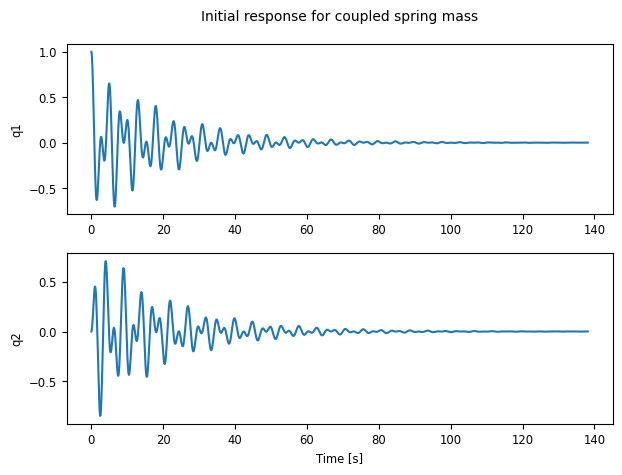

In [4]:
response = ct.initial_response(sys, X0=[1, 0, 0, 0])
out = response.plot()

If you want to play around with the way the data are plotted, you can also use the response object to get direct access to the states and outputs.

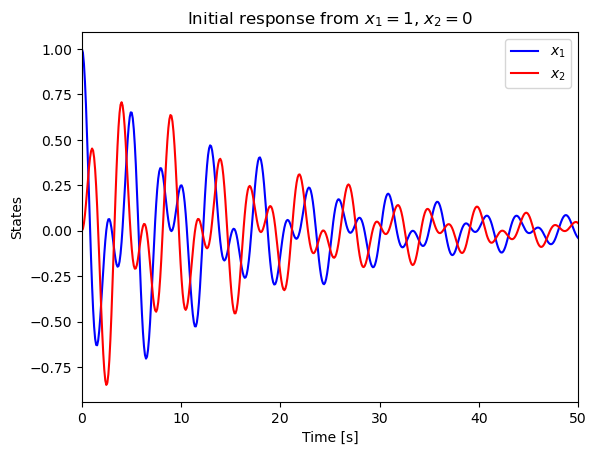

In [5]:
# Plot the outputs of the system on the same graph, in different colors
t = response.time
x = response.states
plt.plot(t, x[0], 'b', t, x[1], 'r')
plt.legend(['$x_1$', '$x_2$'])
plt.xlim(0, 50)
plt.ylabel('States')
plt.xlabel('Time [s]')
plt.title("Initial response from $x_1 = 1$, $x_2 = 0$");

There are also lots of options available in `initial_response` and `.plot()` for tuning the plots that you get.

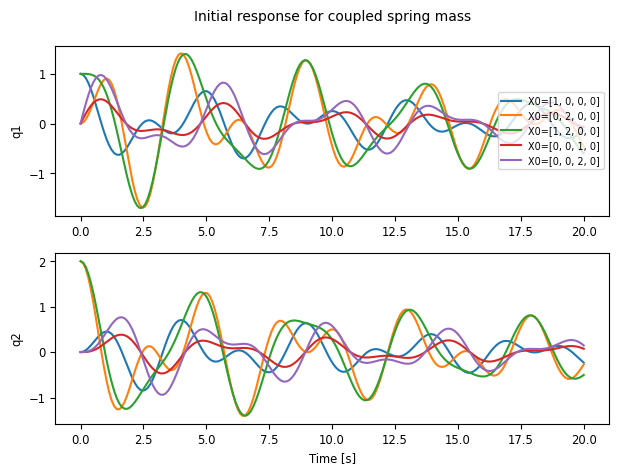

In [6]:
# Do some Python magic to get different colors
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])

for X0 in [[1, 0, 0, 0], [0, 2, 0, 0], [1, 2, 0, 0], [0, 0, 1, 0], [0, 0, 2, 0]]:
  response = ct.initial_response(sys, T=20, X0=X0)
  response.plot(color=next(colors), label=f"{X0=}")

### Step response

Similar to `initial_response`, you can also generate a step response for a linear system using the `step_response` function, which returns a time  response object:

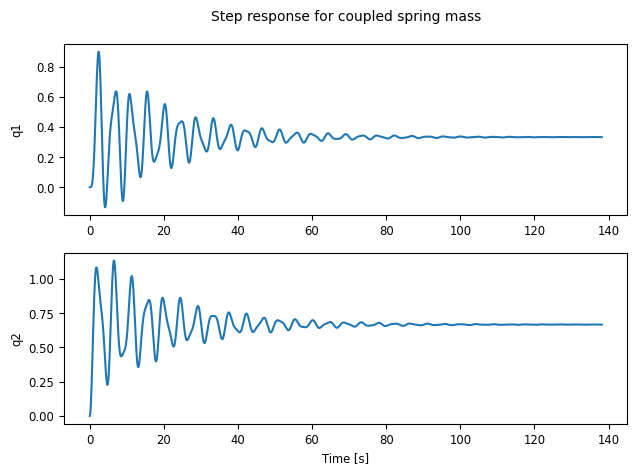

In [7]:
out = ct.step_response(sys).plot()

We can analyze the properties of the step response using the `stepinfo` command:

In [8]:
step_info = ct.step_info(sys)
print("Input 0, output 0 rise time = ",
      step_info[0][0]['RiseTime'], "seconds\n")
step_info

Input 0, output 0 rise time =  0.6153902252990775 seconds



[[{'RiseTime': 0.6153902252990775,
   'SettlingTime': 89.02645259326653,
   'SettlingMin': -0.13272845655369417,
   'SettlingMax': 0.9005994876222034,
   'Overshoot': 170.17984628666102,
   'Undershoot': 39.81853696610825,
   'Peak': 0.9005994876222034,
   'PeakTime': 2.3589958636464634,
   'SteadyStateValue': 0.33333333333333337}],
 [{'RiseTime': 0.6153902252990775,
   'SettlingTime': 73.6416969607896,
   'SettlingMin': 0.2276019820782241,
   'SettlingMax': 1.13389337710215,
   'Overshoot': 70.08400656532254,
   'Undershoot': 0,
   'Peak': 1.13389337710215,
   'PeakTime': 6.564162403190159,
   'SteadyStateValue': 0.6666666666666665}]]

Note that by default the inputs are not included in the step response (since they are a bit boring), but you can change that:

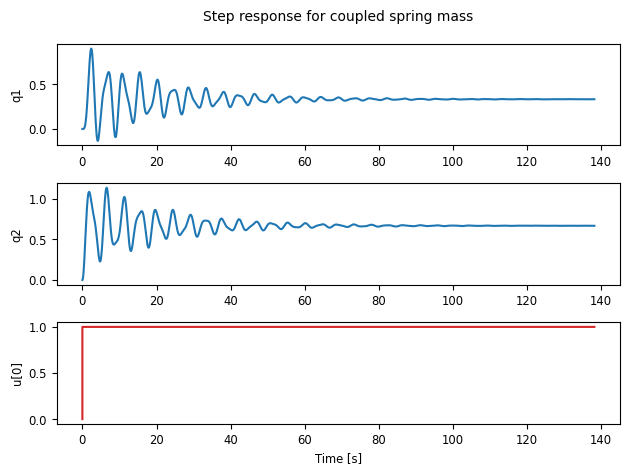

In [9]:
stepresp = ct.step_response(sys)
out = stepresp.plot(plot_inputs=True)

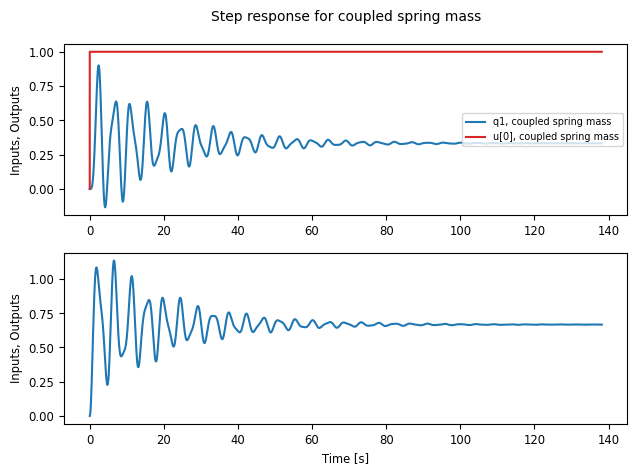

In [10]:
out = stepresp.plot(plot_inputs='overlay')

In [11]:
# Look at the "shape" of the step response
print(f"{stepresp.time.shape=}")
print(f"{stepresp.inputs.shape=}")
print(f"{stepresp.states.shape=}")
print(f"{stepresp.outputs.shape=}")

stepresp.time.shape=(1348,)
stepresp.inputs.shape=(1, 1, 1348)
stepresp.states.shape=(4, 1, 1348)
stepresp.outputs.shape=(2, 1, 1348)


## Forced response

To compute the response to an input, using the convolution equation, we can use the `forced_response` function:

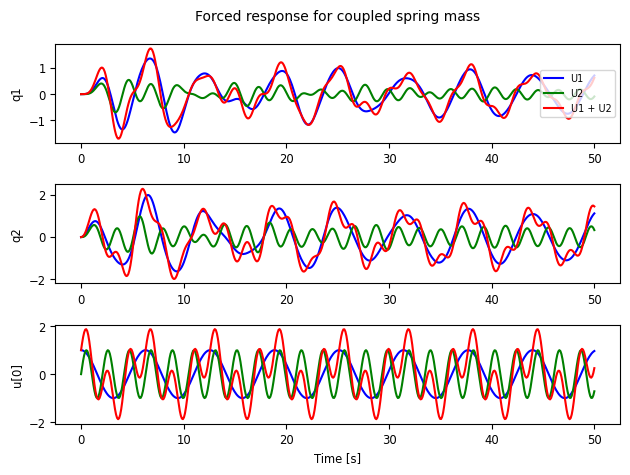

In [12]:
T = np.linspace(0, 50, 500)
U1 = np.cos(T)
U2 = np.sin(3 * T)

resp1 = ct.forced_response(sys, T, U1)
resp2 = ct.forced_response(sys, T, U2)
resp3 = ct.forced_response(sys, T, U1 + U2)

# Plot the individual responses
resp1.sysname = 'U1'; resp1.plot(color='b')
resp2.sysname = 'U2'; resp2.plot(color='g')
resp3.sysname = 'U1 + U2'; resp3.plot(color='r');

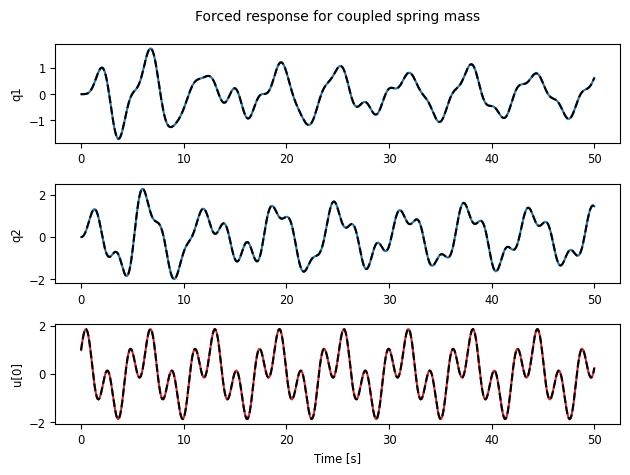

In [13]:
# Show that the system response is linear
out = resp3.plot()
axs = ct.get_plot_axes(out)
axs[0, 0].plot(resp1.time, resp1.outputs[0] + resp2.outputs[0], 'k--')
axs[1, 0].plot(resp1.time, resp1.outputs[1] + resp2.outputs[1], 'k--')
axs[2, 0].plot(resp1.time, resp1.inputs[0] + resp2.inputs[0], 'k--');

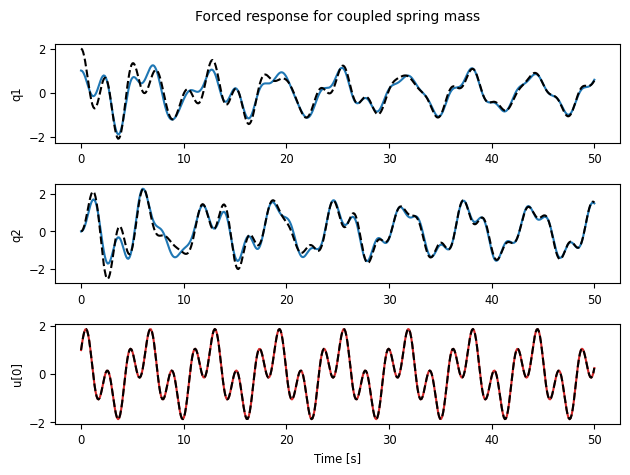

In [14]:
# Show that the forced response from non-zero initial condition is not linear
X0 = [1, 0, 0, 0]
resp1 = ct.forced_response(sys, T, U1, X0=X0)
resp2 = ct.forced_response(sys, T, U2, X0=X0)
resp3 = ct.forced_response(sys, T, U1 + U2, X0=X0)

out = resp3.plot()
axs = ct.get_plot_axes(out)
axs[0, 0].plot(resp1.time, resp1.outputs[0] + resp2.outputs[0], 'k--')
axs[1, 0].plot(resp1.time, resp1.outputs[1] + resp2.outputs[1], 'k--')
axs[2, 0].plot(resp1.time, resp1.inputs[0] + resp2.inputs[0], 'k--');

### Frequency response

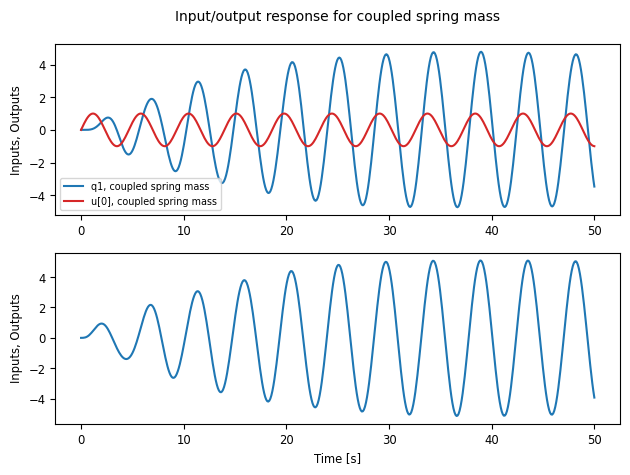

In [15]:
# Manual computation of the frequency response
resp = ct.input_output_response(sys, T, np.sin(1.35 * T))

out = resp.plot(plot_inputs='overlay', legend_loc='lower left')

The magnitude and phase of the frequency response is controlled by the transfer function,

$$
G(s) = C (sI - A)^{-1} B + D
$$

which can be computed using the `ss2tf` function:

In [16]:
# Create SISO transfer functions, since we don't have slycot
G1 = ct.ss2tf(sys[0, 0], name='u to q1')
G2 = ct.ss2tf(sys[1, 0], name='u to q2')
print(G1)
print(G2)

<TransferFunction>: u to q1
Inputs (1): ['u[0]']
Outputs (1): ['q1']


                  4
-------------------------------------
s^4 + 0.2 s^3 + 8.01 s^2 + 0.8 s + 12

<TransferFunction>: u to q2
Inputs (1): ['u[0]']
Outputs (1): ['q2']


          2 s^2 + 0.2 s + 8
-------------------------------------
s^4 + 0.2 s^3 + 8.01 s^2 + 0.8 s + 12



In [17]:
# Gain and phase for the simulation above
from math import pi
val = G1(1.35j)
print(f"{G1(1.35j)=}")
print(f"Gain: {np.absolute(val)}")
print(f"Phase: {np.angle(val)}", " (", np.angle(val) * 180/pi, "deg)")

G1(1.35j)=(3.3300564744031984-2.706863274436471j)
Gain: 4.291431568743418
Phase: -0.6825322008139448  ( -39.106214488414615 deg)


In [18]:
# Gain and phase at s = 0 (= steady state step response)
print(f"{G1(0)=}")
print("Final value of step response:", stepresp.outputs[0, 0, -1])

G1(0)=(0.3333333333333333+0j)
Final value of step response: 0.33297541813724874


The frequency response across all frequencies can be computed using the `frequency_response` function:

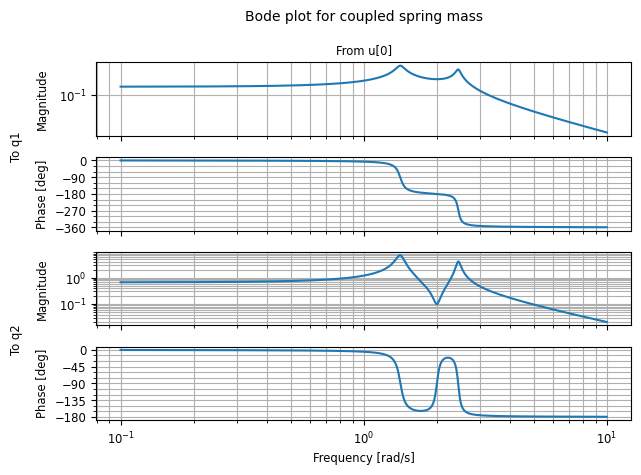

In [19]:
freqresp = ct.frequency_response(sys)
out = freqresp.plot()

By default, frequency responses are plotted using a "Bode plot", which plots the log of the magnitude and the (linear) phase against the log of the forcing frequency.

You can also call the Bode plot command directly, and change the way the data are presented:

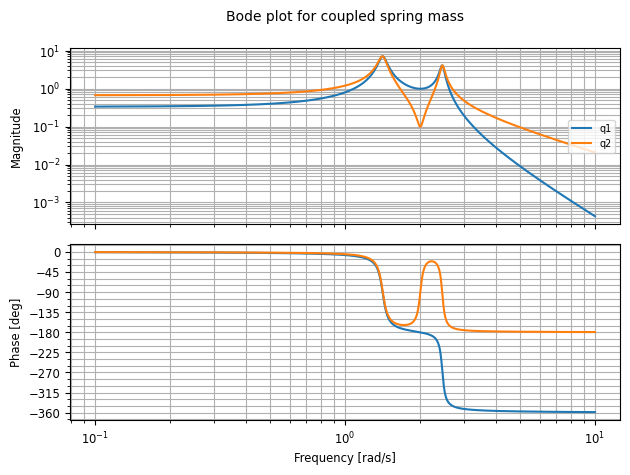

In [20]:
out = ct.bode_plot(sys, overlay_outputs=True)

Note the "dip" in the frequency response for y[1] at frequency 2 rad/sec, which corresponds to a "zero" of the transfer function.

This dip becomes even more pronounced in the case of low damping coefficient $c$:

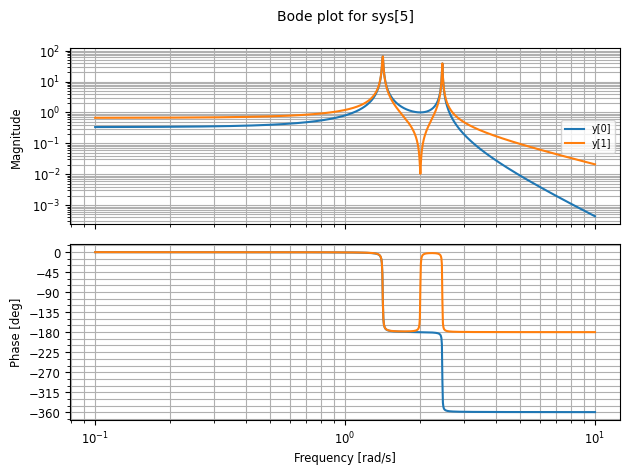

In [21]:
out = ct.frequency_response(
    coupled.linearize([0, 0, 0, 0], [0], params={'c': 0.01})
).plot(overlay_outputs=True)

## Additional resources
* [Code for FBS2e figures](https://fbswiki.org/wiki/index.php/Category:Figures): Python code used to generate figures in FBS2e
* [Python-control documentation for plotting time responses](https://python-control.readthedocs.io/en/0.10.0/plotting.html#time-response-data)
* [Python-control documentation for plotting frequency responses](https://python-control.readthedocs.io/en/0.10.0/plotting.html#frequency-response-data)
* [Python-control examples](https://python-control.readthedocs.io/en/0.10.0/examples.html): lots of Python and Jupyter examples of control system analysis and design
